---
# Benchmarking 2D / 3D PORTRAITS
---

In [1]:
# import
from benchmark_main import *


2022-10-19 22:20:13.982770: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-19 22:20:13.983793: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### TOY NETWORKS

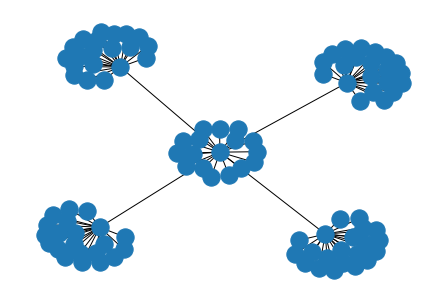

In [5]:
# TREE GRAPH
organism = 'tree'
n = 100 # number of nodes
r = 20 # branching factor
G = nx.full_rary_tree(r, n)
nx.draw(G)
# STAR GRAPH
#organism = 'star'
#n = 1000
#G = nx.star_graph(n)

# CYCLE GRAPH
#organism = 'cycle'
#n = 1000
#G = nx.cycle_graph(n)

### GEOMETRIES 

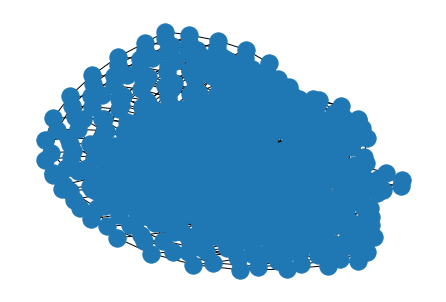

In [11]:
# 3D grid 
organism = 'grid'

G_grid = nx.grid_graph([10,10,10],periodic=False)
G = G_grid 
nx.draw(G)

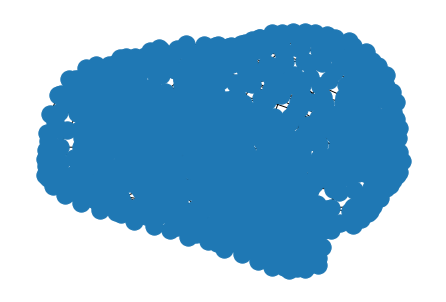

In [7]:
# Torus 
organism = 'torus'

G_tor = nx.grid_2d_graph(48,24,periodic=True) #24,12
G = G_tor
nx.draw(G)

## NETWORK

In [12]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 1000
Number of edges: 2700
Network density: 0.5%


+ Feature Collection 

In [13]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESSCENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)

In [14]:
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 

---
## LAYOUTS
---

In [15]:
# Adjacency
A = nx.adjacency_matrix(G)
adj = A.toarray()
DM_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))

/var/folders/ln/rnln21vd6jn23nm9wwr0jgs00000gn/T/ipykernel_67610/4020369582.py:2: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



In [16]:
r = .8 # restart probability; originally 0.8
alpha = 1.0 
# alpha = 0.5 # --> better results for torus 

DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))

DM_m_df = pd.DataFrame(DM_m)
#print(DM_m_df.sum(axis=0))

DM_m_transposed = DM_m_df.T

metric = "cosine" 
DM_m_new = pd.DataFrame(distance.squareform(distance.pdist(DM_m_transposed, metric)))
DM_m_new.index = list(G.nodes())
DM_m_new.columns = list(G.nodes())
DM_m = DM_m_new

In [17]:
metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))
DM_cent.index = list(G.nodes())
DM_cent.columns = list(G.nodes())

In [18]:
feature = 'adj'
DM = DM_adj

#feature = 'rwr'
#DM = DM_m

#feature = 'cent'
#DM = DM_cent

____________
## VISUAL PRE-SETTINGS
____________

### GENERAL NODE + EDGE PARAMETERS

In [19]:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 1

opacity_nodes = 1.0
node_edge_col = None


# Node sizes 

scalef= 0.2
size = list([2]*len(G.nodes())) # list(draw_node_degree(G, scalef).values())

scalef= 0.05
size3d = list([1]*len(G.nodes())) #list(draw_node_degree_3D(G, scalef).values())

### SPECIFIC NODE + EDGE PARAMETERS

In [33]:
color_method = 'YlOrRd'
d_to_be_col = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)
colours = list(color_nodes_from_dict(G, d_to_be_col, color_method).values())

---
## 2D SPRING
---

In [34]:
%%time 

# ---------------------------------------
# Spring
# ---------------------------------------
#forceatlas2 = ForceAtlas2()
#posG_spring = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)
posG_spring2D = nx.spring_layout(G, dim = 2)

CPU times: user 5.52 s, sys: 54.3 ms, total: 5.57 s
Wall time: 5.69 s


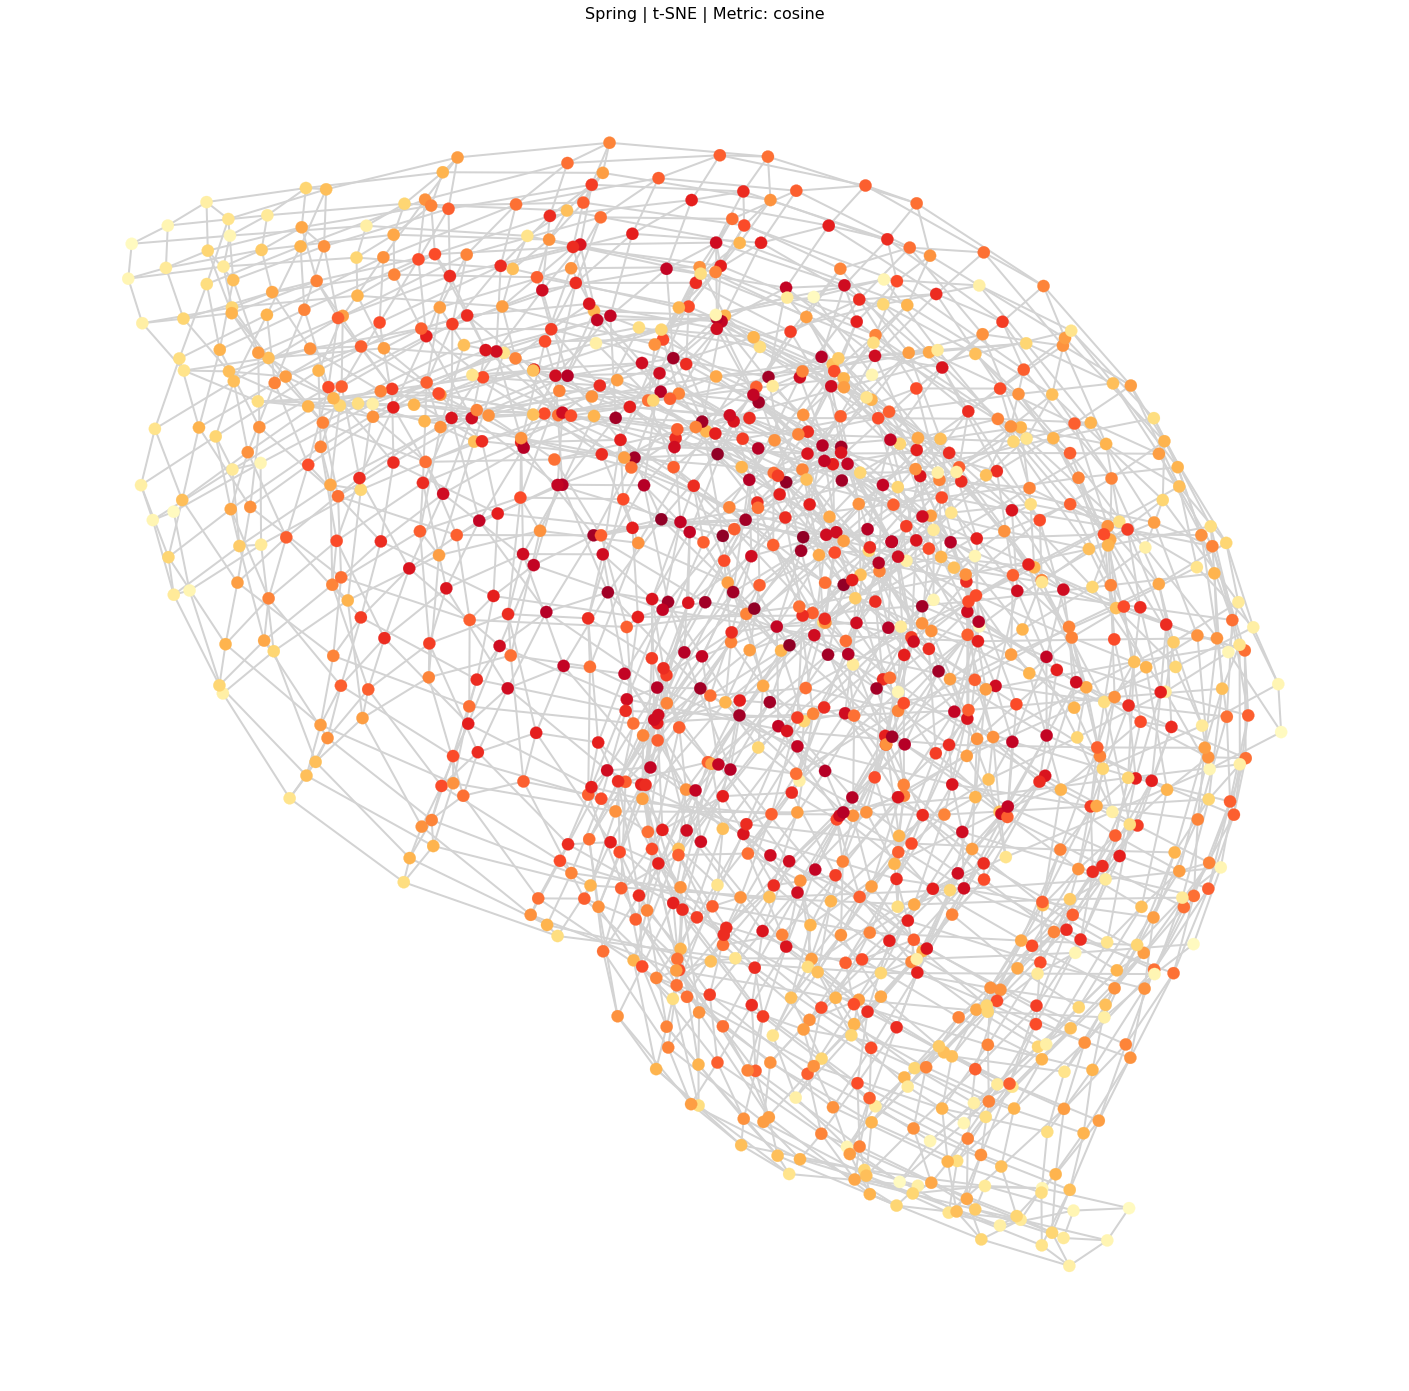

In [36]:
plt.figure(figsize=(25,25))
plt.title('Spring | t-SNE | Metric: '+metric, size= 16)

nx.draw_networkx_nodes(G, posG_spring2D, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, 
                       node_size= 150, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_spring2D, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

#plt.savefig('output_plots/2Dspring.png')

plt.show()

---
## 2D PORTRAIT
---

In [37]:
n_neighbors = 10 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.01 # defines how dense points are stacked together 
metric ='cosine'

In [38]:
%%time 
umap = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 5.28 s, sys: 125 ms, total: 5.4 s
Wall time: 5.01 s


In [39]:
posG_umap = get_posG_2D(G.nodes(), umap)
posG_complete_umap = {key:posG_umap[key] for key in G.nodes()}

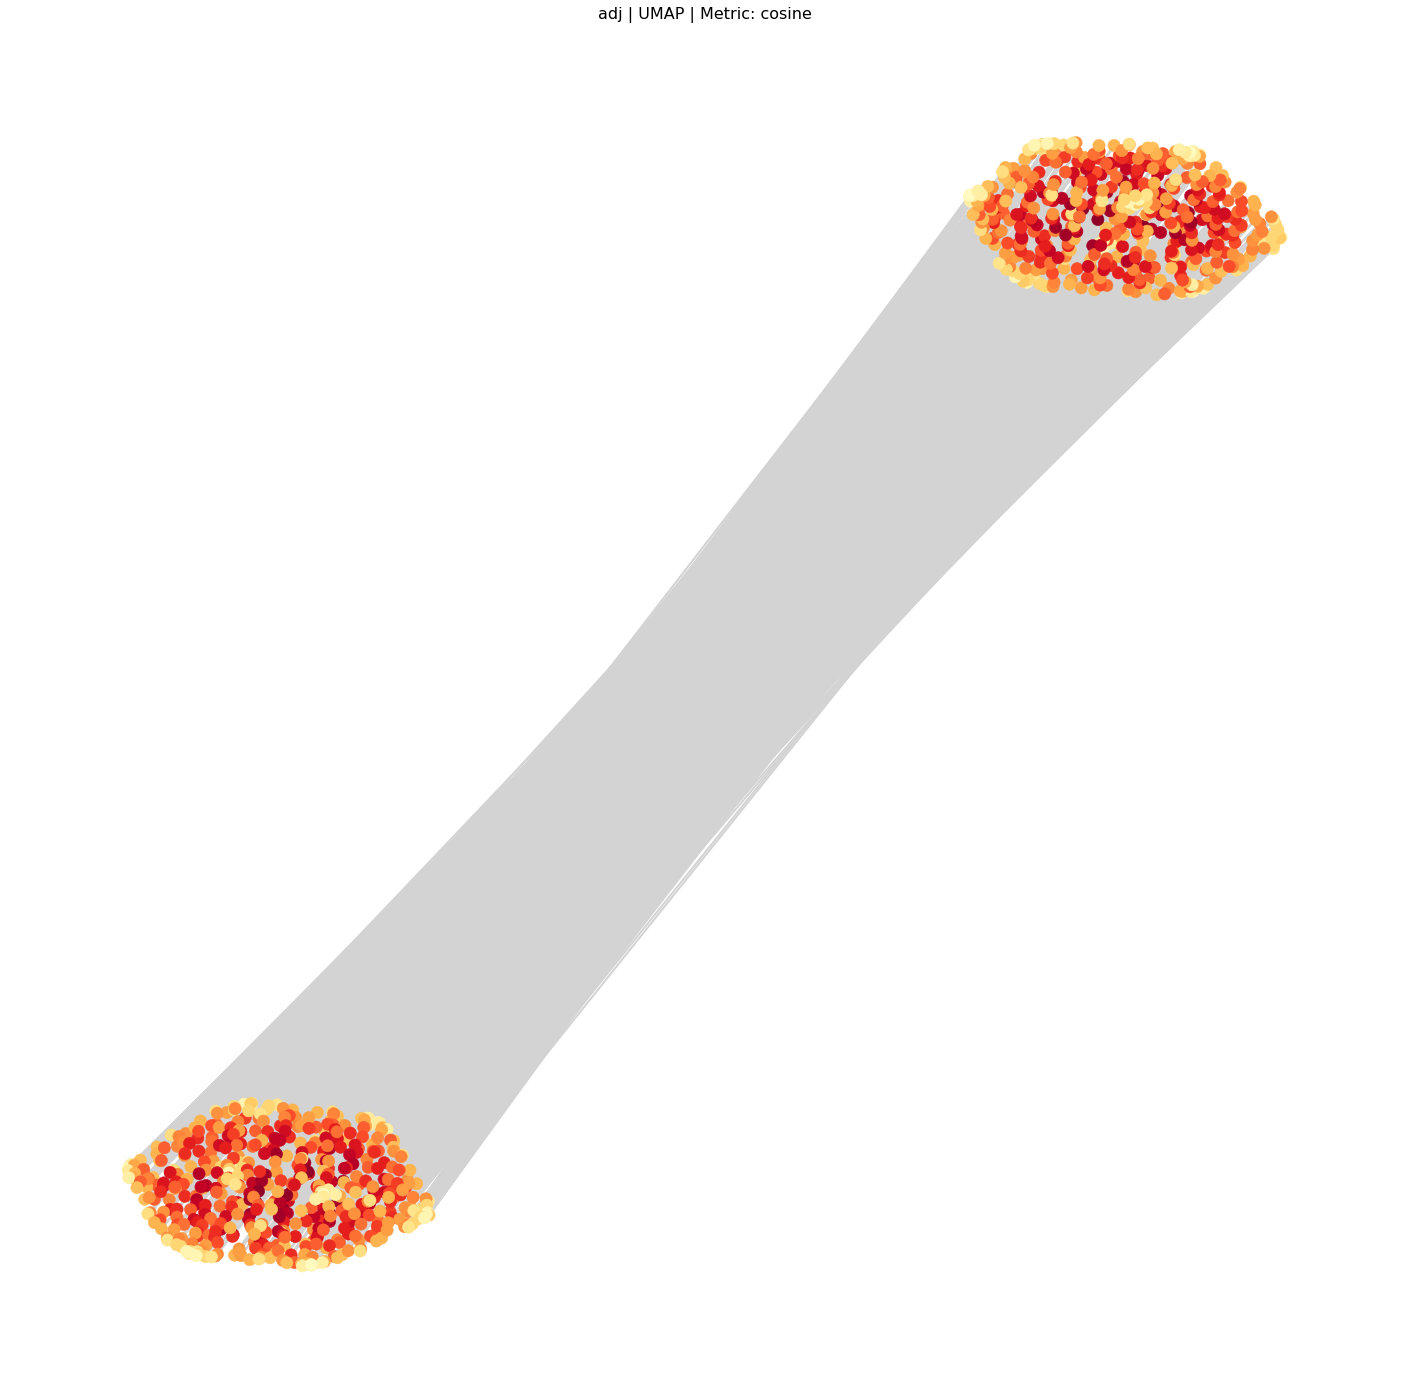

In [41]:
plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 150, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

#plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

---
## 3D SPRING
---

In [49]:
posG_spring3D = nx.spring_layout(G, dim = 3)

spring_nodes = get_trace_nodes_3D(posG_spring3D, None, colours, 4) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D, edge_colordark, opac=1)

spring_data = [spring_nodes, spring_edges]

In [51]:
print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)
'''fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                    dragmode="turntable",
                    #annotations=annotations,
                ))'''

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=True)

Spring Layout: grid


'output_plots/3Dtoynetwork_spring_grid.html'

---
## 3D PORTRAIT
---

In [52]:
n_neighbors = 10# balance between local and global structure in the data
spread = 1.0
min_dist = 0.01 # defines how dense points are stacked together 
metric='cosine'

In [53]:
%%time 
umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 5.71 s, sys: 407 ms, total: 6.12 s
Wall time: 5.74 s


In [54]:
posG_3Dumap = get_posG_3D(list(G.nodes()), umap_3D)
posG_3D_complete_umap = {key:posG_3Dumap[key] for key in G.nodes()}

In [55]:
%%time 
umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap, None, colours, 4) # size3d)
umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap, edge_colordark, 1.0) 

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

CPU times: user 60.9 ms, sys: 2.77 ms, total: 63.7 ms
Wall time: 62.2 ms


In [56]:
fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

'''fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    '''

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

'output_plots/3Dtoynetwork_umap_adj_grid.html'

In [60]:
export_to_csv3D(path = '', 
                layout_namespace = '3Dcube_'+feature, 
                posG = posG_3D_complete_umap, 
                colors = colours)